# Baltimore Real Estate Analysis: 2024 Q4

While my partner and I think about a potential move to Baltimore, MD, I thought it would make sense to build an ML model that can use historical data to predict what price we might have to pay for a house, given a set of requirements (number of bedroms, square feet, etc.).

The following project consists of a sequence of steps that scrapes Realtor.com real estate data, processes the data to be useable for modeling, and then predicts housing prices based on selected parameters.

---
### Install required packages
---

I first install all the system packages required for this project. These include a web scraping library called homeharvest, and data visualization (matplotlib and seaborn) and modeling (scikit-learn, xgboost) library.

More information on how homeharvest works can be found here:
https://github.com/Bunsly/HomeHarvest/blob/master/README.md

In [1988]:
!pip install homeharvest matplotlib seaborn scikit-learn xgboost

In [1989]:
!pip install xgboost

Then we must import the required modules:

In [1990]:
# Web Scraper
from homeharvest import scrape_property

# Standard modules for dataframe/array operations
import pandas as pd
import numpy as np
from datetime import datetime

# Data visualization
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
import xgboost as xgb

---
### Web Scraping Realtor.com
---

First we will set the parameters for the location of interest, as well as the type of homes to include, and the date ranges.

I selected the entire city of Baltimore, but I could only included a specific zip code if I narrow down my location of interest later.

Rather that looking at the list price, I decide to only look at selling price. This gives a more accurate prediction of what I might actually pay, rather than the price that sellers are hoping to receive.

To get a relatively high number of observations, I include a date range from January 1, 2023 through present. 

Lastly, I only include single-family, townhomes, and condos. These can change depending on the type of property you're interested in buying. The parameter options can be found in the homeharvest documentation.

In [1991]:
#enter zip code of interest
location = 'Baltimore, MD'
listing_type = 'sold' #{sold, for_sale, for_rent}
date_from = "2023-06-20"
date_to = "2024-12-31"
property_type=['single_family', 'townhomes', 'condos']
limit = 10000
# past_days = 90
# radius=10

We can then pass these parameters through the scrape_property function:

In [1992]:
listings = scrape_property(
    location=location,
    listing_type=listing_type,
    # past_days=past_days,
    # radius=radius,
    date_from=date_from,
    date_to=date_to,
    extra_property_data=True,
    mls_only=True,
    limit=limit
)

The output takes the form of a pandas dataframe.

You can save the output as a .csv file if needed, but in this case we will just make a copy of the dataframe and continue with our analysis.

In [1993]:
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# filename = f"realtor_{location}_{listing_type}_{radius}_{timestamp}.csv"
# listings.to_csv(filename, index=False)

df = listings.copy()

---
### Exploratory Analysis and Data Preparation
----

Now we take a look at the data, it's schema, and we can visualize it to see distributions. First we can see the number of rows and columns.

In [1994]:
f"There are {df.shape[0]} rows and {df.shape[1]} columns."

'There are 7711 rows and 57 columns.'

Now we look at the first five rows of data to get a first visual of what we're working with.

In [1995]:
df.head(5)

,property_url,property_id,listing_id,mls,mls_id,status,text,style,full_street_line,street,...,builder_id,builder_name,office_id,office_mls_set,office_name,office_email,office_phones,nearby_schools,primary_photo,alt_photos
0,https://www.realtor.com/realestateandhomes-det...,6217874272,2972169356,PHPA,MDBA2139856,SOLD,ONLINE AUCTION: Bidding begins 10/10 @ 10:00 A...,TOWNHOMES,3131 Lawnview Ave,3131 Lawnview Ave,...,<NA>,<NA>,4604752,O-PHPA-ASHLA1,Ashland Auction Group Llc,<NA>,"[{'number': '4104883124', 'type': 'BUSINESS_PH...",Baltimore City Public Schools,http://ap.rdcpix.com/b9e5a2316ef84769c006a0e75...,http://ap.rdcpix.com/b9e5a2316ef84769c006a0e75...
1,https://www.realtor.com/realestateandhomes-det...,6376525842,2966343493,PHPA,MDBA2121702,SOLD,100% FINANCING AVAILABLE! Back on the market! ...,TOWNHOMES,2711 Ashland Ave,2711 Ashland Ave,...,<NA>,<NA>,2992028,O-PHPA-EXXP1,"Exp Realty, LLC",MD.Broker@exprealty.net,"[{'number': '8888607369', 'type': 'Office', 'p...",Baltimore City Public Schools,http://ap.rdcpix.com/dc503300e834a0690030c80f4...,http://ap.rdcpix.com/dc503300e834a0690030c80f4...
2,https://www.realtor.com/realestateandhomes-det...,5877649819,2974518633,PHPA,MDBA2145710,SOLD,ONLINE AUCTION: Bidding begins 12/12/2024 @ 10...,TOWNHOMES,520 S Newkirk St,520 S Newkirk St,...,<NA>,<NA>,4604752,O-PHPA-ASHLA1,Ashland Auction Group Llc,<NA>,"[{'number': '4104883124', 'type': 'BUSINESS_PH...",Baltimore City Public Schools,http://ap.rdcpix.com/780a6fd936f1a83695528502e...,http://ap.rdcpix.com/780a6fd936f1a83695528502e...
3,https://www.realtor.com/realestateandhomes-det...,6204572256,2975166313,PHPA,MDBC2112960,SOLD,"Multiple offers have been received, requesting...",TOWNHOMES,413 52nd St,413 52nd St,...,<NA>,<NA>,3895463,O-PHPA-CCRL6,Cummings & Co.,admin@cummingsrealtors.com,"[{'number': '4108230033', 'type': 'Office', 'p...",Baltimore County Public Schools,http://ap.rdcpix.com/c653127f81711aae20b90e630...,http://ap.rdcpix.com/c653127f81711aae20b90e630...
4,https://www.realtor.com/realestateandhomes-det...,9567546422,2975470152,PHPA,MDBA2148170,SOLD,WOW.stunning multi-unit that was fully rehabbe...,MULTI_FAMILY,2735 N Calvert St,2735 N Calvert St,...,<NA>,<NA>,3895463,O-PHPA-CCRL6,Cummings & Co.,admin@cummingsrealtors.com,"[{'number': '4108230033', 'type': 'Office', 'p...",Baltimore City Public Schools,http://ap.rdcpix.com/f987963fa1d8d90a7fb9825ac...,http://ap.rdcpix.com/f987963fa1d8d90a7fb9825ac...


Straight away we can see there are several variables we won't need. For example, we won't need street addresses, MLS IDs, builder names, or any data on the listing agents.

Lets take a closer look at all of the column in the dataset. This will help us narrow down the dataset in a bit.

In [1996]:
df.columns

Index(['property_url', 'property_id', 'listing_id', 'mls', 'mls_id', 'status',
       'text', 'style', 'full_street_line', 'street', 'unit', 'city', 'state',
       'zip_code', 'beds', 'full_baths', 'half_baths', 'sqft', 'year_built',
       'days_on_mls', 'list_price', 'list_price_min', 'list_price_max',
       'list_date', 'sold_price', 'last_sold_date', 'assessed_value',
       'estimated_value', 'new_construction', 'lot_sqft', 'price_per_sqft',
       'latitude', 'longitude', 'neighborhoods', 'county', 'fips_code',
       'stories', 'hoa_fee', 'parking_garage', 'agent_id', 'agent_name',
       'agent_email', 'agent_phones', 'agent_mls_set', 'agent_nrds_id',
       'broker_id', 'broker_name', 'builder_id', 'builder_name', 'office_id',
       'office_mls_set', 'office_name', 'office_email', 'office_phones',
       'nearby_schools', 'primary_photo', 'alt_photos'],
      dtype='object')

While we see several unneccessary variables, we can immidiately see several that will be useful. Common knowledge tells us that square feet, number of rooms, and the year a home is built can tell us a lot about the price of a home. Also how long the home has been on the market should be a useful variable as well.

Lets now look at the datatypes as well as which variables have null values.

In [1997]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7711 entries, 0 to 7710
Data columns (total 57 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   property_url      7711 non-null   object 
 1   property_id       7711 non-null   object 
 2   listing_id        7711 non-null   object 
 3   mls               7711 non-null   object 
 4   mls_id            7711 non-null   object 
 5   status            7711 non-null   object 
 6   text              7561 non-null   object 
 7   style             7711 non-null   object 
 8   full_street_line  7697 non-null   object 
 9   street            7704 non-null   object 
 10  unit              571 non-null    object 
 11  city              7711 non-null   object 
 12  state             7711 non-null   object 
 13  zip_code          7711 non-null   object 
 14  beds              7660 non-null   object 
 15  full_baths        7187 non-null   object 
 16  half_baths        3141 non-null   object 


We can see that there are 7,438 records of sold houses in the dataset. We also see several columns that have null values (e.g., `sqft`, `half_baths`). We will have to investigate and determine how to handle them. We also can see variables that should be numeric, but are currently object datatypes. For example, `year_built` should ideally be a numeric column, as should square feet (`sqft`), `beds`, `full_baths`, etc.

Now lets look at the summary statistics for the variables that are currently numeric.

In [1998]:
df.describe()

,list_price,sold_price,latitude,longitude
count,7.711000e+03,7.711000e+03,7679.000000,7679.000000
mean,2.641765e+05,2.665004e+05,39.312762,-76.615263
std,2.063760e+05,2.008602e+05,0.034706,0.050180
min,1.000000e+03,4.000000e+00,39.171503,-76.824669
25%,1.349000e+05,1.350000e+05,39.285857,-76.650576
50%,2.300000e+05,2.300000e+05,39.308165,-76.611832
75%,3.499995e+05,3.500000e+05,39.339432,-76.580738
max,2.989000e+06,2.525000e+06,39.431016,-76.353828


As of right now, only `list_price` and `sold_price` are interesting numeric variables for this analysis. we will revisit this once we convert the other relevant variables to numeric.The mean list price is $263,157.8 and the mean selling price is $265517.0 for the time period we've selected. 

Let's only keep the columns I consider relevant to this analysis. I copy the list of columns from the `df.columns` output, and comment out the irrelevant ones.

In [1999]:
#drop irrelevant columns
df = df[[
    # 'property_url', 'property_id', 
    # 'listing_id', 
    # 'mls', 'mls_id', 'status',
    # 'text', 'style', 'full_street_line', 'street', 'unit', 'city', 'state',
    # 'zip_code', 
    'beds', 'full_baths', 'half_baths', 'sqft', 'year_built',
    'days_on_mls', 
    # 'list_price', 
    # 'list_price_min', 'list_price_max',
    'list_date', 'sold_price', 
    # 'last_sold_date', 'assessed_value',
    # 'estimated_value', 
    'new_construction', 'lot_sqft', 
    # 'price_per_sqft',
    # 'latitude', 'longitude', 
    # 'neighborhoods', 'county', 'fips_code',
    'stories', 'hoa_fee', 'parking_garage',
    # 'agent_id', 'agent_name',
    # 'agent_email', 'agent_phones', 'agent_mls_set', 'agent_nrds_id',
    # 'broker_id', 'broker_name', 'builder_id', 'builder_name', 'office_id',
    # 'office_mls_set', 'office_name', 'office_email', 'office_phones',
    # 'nearby_schools', 'primary_photo', 'alt_photos'
    ]]

df.head(5)

,beds,full_baths,half_baths,sqft,year_built,days_on_mls,list_date,sold_price,new_construction,lot_sqft,stories,hoa_fee,parking_garage
0,3,1,<NA>,1264,1926,105,2024-09-16,96800,False,1600,2,0,<NA>
1,4,3,<NA>,<NA>,1920,253,2024-04-18,199000,False,<NA>,3,0,<NA>
2,4,2,<NA>,1702,1920,53,2024-11-04,148500,False,<NA>,2,0,<NA>
3,3,1,<NA>,1208,1943,38,2024-11-19,210000,False,2160,2,0,<NA>
4,4,<NA>,<NA>,2996,1900,31,2024-11-26,600000,False,<NA>,<NA>,<NA>,<NA>


We first alter the datatypes to reflect the correct types. `list_date` coverts to datetime, while the handful of variables identified as object above convert to numeric.

In [2000]:
df['list_date'] = pd.to_datetime(df['list_date'])

def to_numeric(data, col):
    data[col] = pd.to_numeric(data[col])
    return data

cols_to_numeric = ['beds', 'half_baths', 'sqft', 'days_on_mls', 'lot_sqft', 'hoa_fee', 'stories']

for col in cols_to_numeric:
    col = str(col)
    to_numeric(df, col)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7711 entries, 0 to 7710
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   beds              7660 non-null   float64       
 1   full_baths        7187 non-null   object        
 2   half_baths        3141 non-null   float64       
 3   sqft              6617 non-null   float64       
 4   year_built        7649 non-null   object        
 5   days_on_mls       7678 non-null   float64       
 6   list_date         7711 non-null   datetime64[ns]
 7   sold_price        7711 non-null   int64         
 8   new_construction  7711 non-null   bool          
 9   lot_sqft          5409 non-null   float64       
 10  stories           7461 non-null   float64       
 11  hoa_fee           7504 non-null   float64       
 12  parking_garage    1294 non-null   object        
dtypes: bool(1), datetime64[ns](1), float64(7), int64(1), object(3)
memory usage: 7

After altering the datatypes and printing `df.info()`, we see that we have the correct datatypes.

Next, we'll handle the null values. We start by looking at how many unuque values we have for each column.

In [2001]:
df.nunique()

beds                  14
full_baths             8
half_baths             5
sqft                1907
year_built           173
days_on_mls          359
list_date            756
sold_price          1551
new_construction       2
lot_sqft            2022
stories                7
hoa_fee              520
parking_garage         7
dtype: int64

Let's go through the variables we intend to use in the model that have missing data.

In [2002]:
df['half_baths'].unique()

array([nan,  1.,  2.,  4.,  3.,  6.])

We can see the value of 'nan' appears for `half_baths`. We'll likely see this behavior in other variables as well and will need to decide how we want to handle this. It's also interesting to see the absence of zero as a possible values. You don't need much domain expertise to know that many houses do not come with a half-bath at all. My initial guess is that these 'nan' values actually are meant to indicate there are zero half-baths. In other words, it makes sense for a realtor to be inputting their listing data into Realtor.com, and they are presented with the option of "not applicable" to a unit that does not have a half-bath. For this reason, we replace 'nan' values with 0.

In [2003]:
df['half_baths'] = df['half_baths'].fillna(0)
df['half_baths'].unique()

array([0., 1., 2., 4., 3., 6.])

We can use the same assumption for `full_baths`, `stories`, `hoa_fee` and `parking_garage`.

In [2004]:
df['full_baths'].unique()

array([1, 3, 2, <NA>, 4, 5, 6, 10, 8], dtype=object)

In [2005]:
df['full_baths'] = pd.to_numeric(df['full_baths'])
df['full_baths'] = df['full_baths'].fillna(0)
df['full_baths'].unique()

array([ 1.,  3.,  2.,  0.,  4.,  5.,  6., 10.,  8.])

In [2006]:
df['stories'].unique()

array([ 2.,  3., nan,  1.,  4.,  5.,  6.,  7.])

In [2007]:
df['stories'] = df['stories'].fillna(0)
df['stories'].unique()

array([2., 3., 0., 1., 4., 5., 6., 7.])

In [2008]:
df['hoa_fee'].unique()

array([0.000e+00,       nan, 5.820e+02, 3.160e+02, 7.300e+01, 7.600e+02,
       6.190e+02, 4.000e+02, 5.200e+01, 3.750e+02, 2.500e+02, 9.000e+00,
       5.450e+02, 5.000e+02, 2.060e+02, 1.033e+03, 6.200e+02, 6.000e+01,
       1.850e+02, 3.250e+02, 7.210e+02, 1.785e+03, 9.000e+01, 6.860e+02,
       2.400e+01, 3.300e+01, 5.630e+02, 5.250e+02, 2.357e+03, 2.000e+00,
       2.950e+02, 7.070e+02, 3.400e+02, 1.830e+02, 9.420e+02, 3.440e+02,
       1.558e+03, 2.550e+02, 6.470e+02, 1.000e+00, 7.500e+01, 8.300e+01,
       1.100e+01, 6.300e+02, 3.450e+02, 7.940e+02, 2.490e+02, 4.400e+01,
       1.373e+03, 3.910e+02, 6.400e+02, 8.620e+02, 5.840e+02, 7.370e+02,
       8.500e+01, 8.370e+02, 4.530e+02, 7.550e+02, 5.800e+01, 1.922e+03,
       2.540e+02, 4.002e+03, 3.420e+02, 4.950e+02, 1.990e+03, 2.027e+03,
       2.400e+02, 1.080e+03, 1.107e+03, 1.500e+02, 3.320e+02, 1.208e+03,
       1.115e+03, 3.000e+00, 1.450e+03, 2.860e+02, 6.520e+02, 1.635e+03,
       9.710e+02, 7.790e+02, 3.900e+01, 2.030e+03, 

In [2009]:
df['hoa_fee'] = df['hoa_fee'].fillna(0)

In [2010]:
df['parking_garage'].unique()

array([<NA>, 3, 1, 2, 4, 6, 11, 100], dtype=object)

In [2011]:
df['parking_garage'] = pd.to_numeric(df['parking_garage'])
df['parking_garage'] = df['parking_garage'].fillna(0)
df['parking_garage'].unique()

array([  0.,   3.,   1.,   2.,   4.,   6.,  11., 100.])

For `beds`, `sqft`, `lot_sqft`, and `year_built`, we need to implement an alternative solution to fill in the missing data. It doesn't make sense for a home to have zero square feet, or have a building year of zero. So for these variables we'll simply take the mean values for the respective variable and fill the 'nan' values with the mean.

In [2012]:
df['beds'].unique()

array([ 3.,  4.,  2.,  1.,  5., nan,  0.,  7.,  6.,  8.,  9., 10., 11.,
       18., 23.])

In [2013]:
mean_beds = df['beds'].mean()
df['beds'] = df['beds'].fillna(mean_beds)

In [2014]:
mean_sqft = df['sqft'].mean()
df['sqft'] = df['sqft'].fillna(mean_sqft)

In [2015]:
lot_sqft_mean = df['lot_sqft'].mean()
df['lot_sqft'] = df['lot_sqft'].fillna(lot_sqft_mean)

In [2016]:
days_mls = df['days_on_mls'].mean()
df['days_on_mls'] = df['days_on_mls'].fillna(days_mls)

In [2017]:
mean_year_built = df['year_built'].mean()
df['year_built'] = df['year_built'].fillna(mean_year_built)

C:\Users\william.ball\AppData\Local\Temp\ipykernel_83256\2821549015.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['year_built'] = df['year_built'].fillna(mean_year_built)


Now we should not 

In [2018]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7711 entries, 0 to 7710
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   beds              7711 non-null   float64       
 1   full_baths        7711 non-null   float64       
 2   half_baths        7711 non-null   float64       
 3   sqft              7711 non-null   float64       
 4   year_built        7711 non-null   float64       
 5   days_on_mls       7711 non-null   float64       
 6   list_date         7711 non-null   datetime64[ns]
 7   sold_price        7711 non-null   int64         
 8   new_construction  7711 non-null   bool          
 9   lot_sqft          7711 non-null   float64       
 10  stories           7711 non-null   float64       
 11  hoa_fee           7711 non-null   float64       
 12  parking_garage    7711 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(10), int64(1)
memory usage: 730.6 KB


Now we can confirm that there are no missing data in our dataset!

Next, we'll check for duplicate rows and drop them if needed.

In [2019]:
df.loc[df.duplicated()].count()

beds                27
full_baths          27
half_baths          27
sqft                27
year_built          27
days_on_mls         27
list_date           27
sold_price          27
new_construction    27
lot_sqft            27
stories             27
hoa_fee             27
parking_garage      27
dtype: int64

In [2020]:
df = df.drop_duplicates()

In [2021]:
df.loc[df.duplicated()].count()

beds                0
full_baths          0
half_baths          0
sqft                0
year_built          0
days_on_mls         0
list_date           0
sold_price          0
new_construction    0
lot_sqft            0
stories             0
hoa_fee             0
parking_garage      0
dtype: int64

## Feature Understanding

In [2022]:
df['year_built'].value_counts()

year_built
1920.0    1544
1900.0     772
1915.0     233
1910.0     182
1925.0     182
          ... 
1872.0       1
1896.0       1
1894.0       1
1882.0       1
1866.0       1
Name: count, Length: 174, dtype: int64

Text(0, 0.5, 'Count')

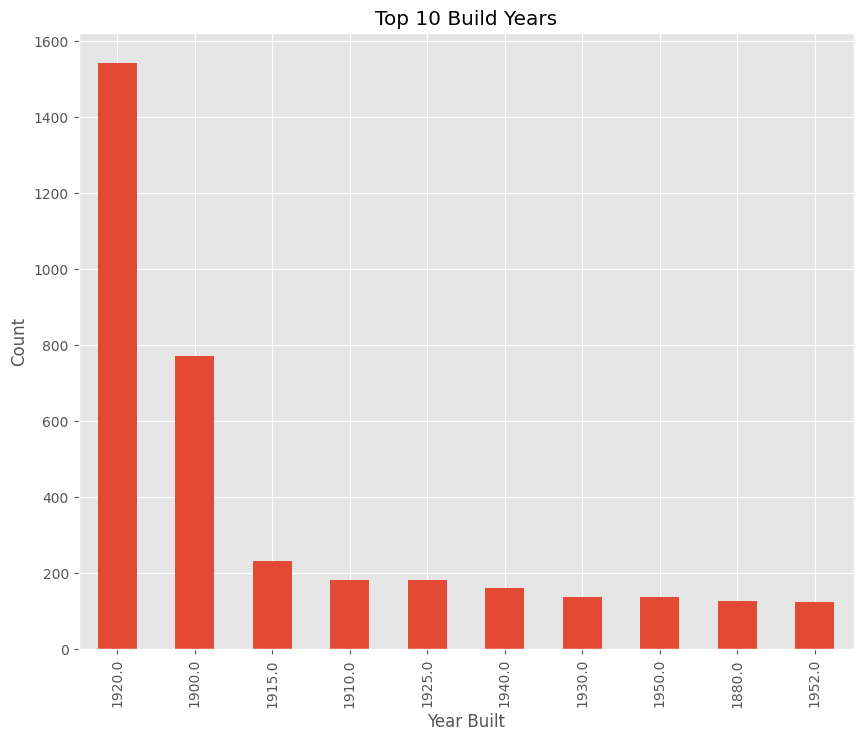

In [2023]:
ax = df['year_built'].value_counts() \
    .head(10) \
    .plot(kind='bar', title='Top 10 Build Years')
ax.set_xlabel('Year Built')
ax.set_ylabel('Count')

Text(0.5, 0, 'Square Feet')

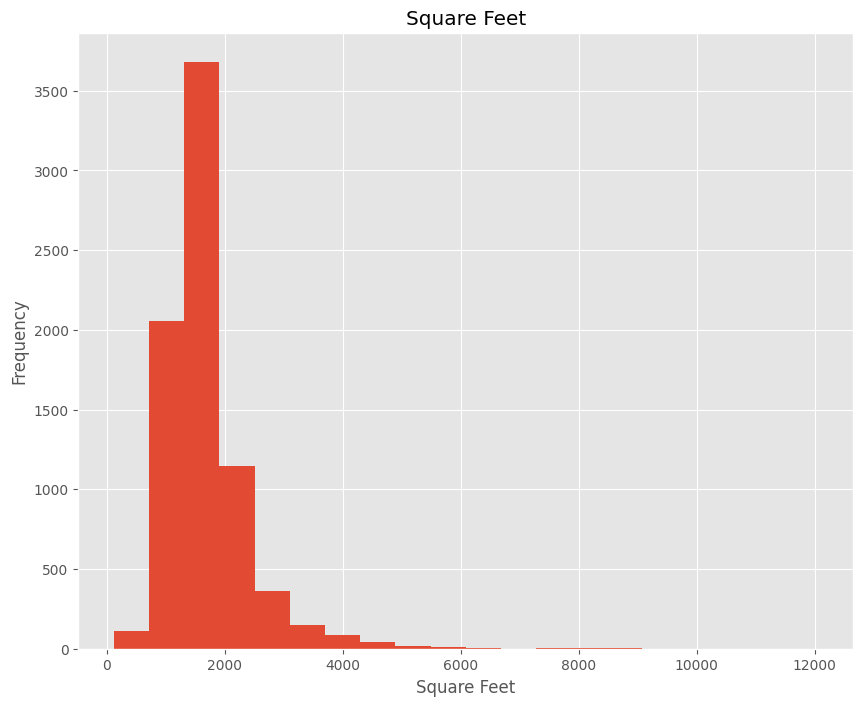

In [2024]:
ax = df['sqft'].plot(kind='hist',
                          bins=20,
                          title='Square Feet')
ax.set_xlabel('Square Feet')

In [2025]:
df['beds'].value_counts()

beds
3.000000     3591
2.000000     1571
4.000000     1378
5.000000      425
0.000000      277
1.000000      199
6.000000      130
3.017624       51
7.000000       35
8.000000       14
9.000000        7
10.000000       3
11.000000       1
18.000000       1
23.000000       1
Name: count, dtype: int64

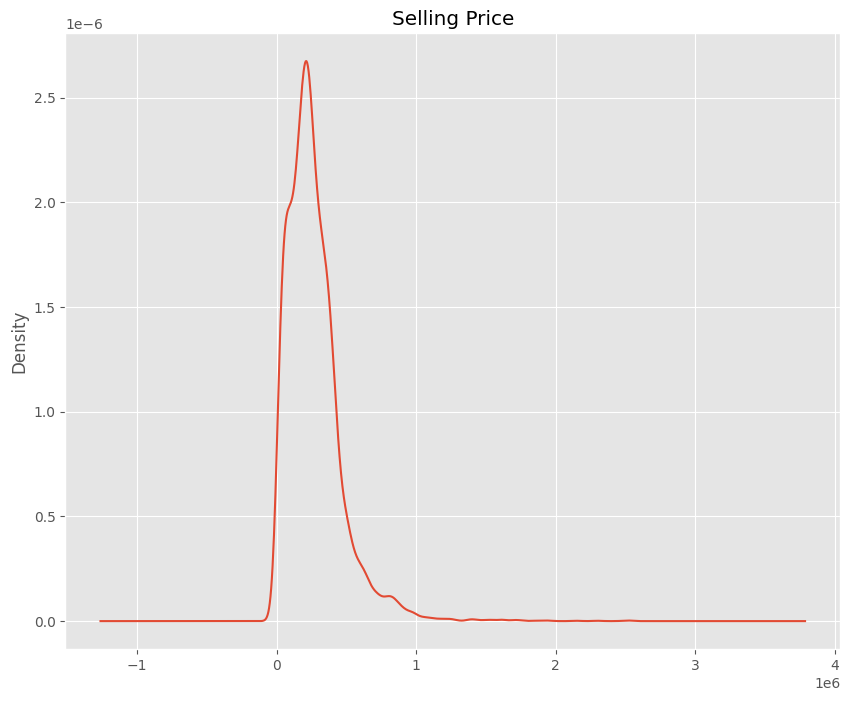

In [2026]:
ax = df['sold_price'].plot(kind='kde',
                           title='Selling Price')

## Feature Relationships

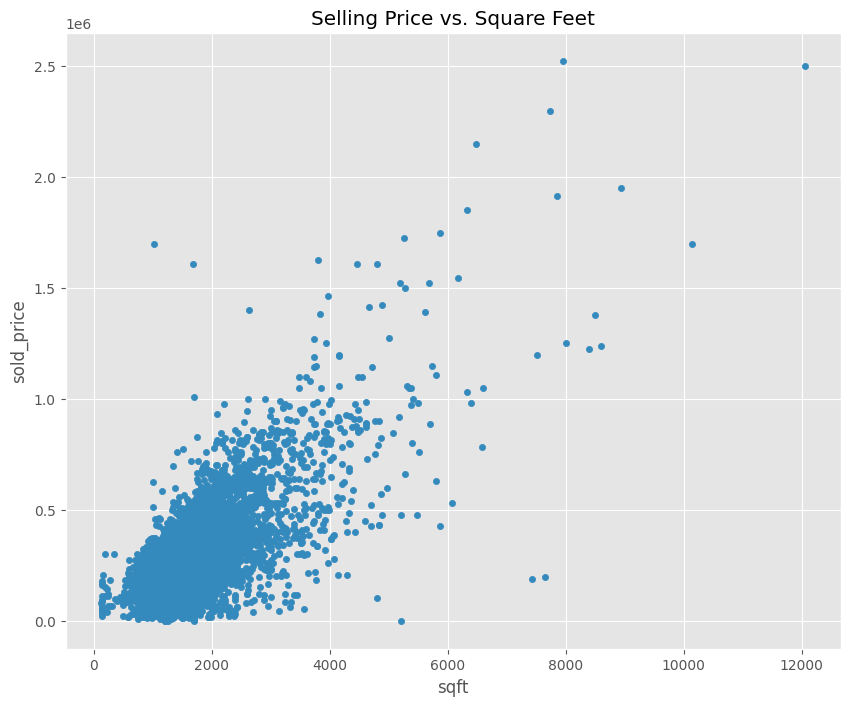

In [2027]:
df.plot(kind='scatter',
        x='sqft',
        y='sold_price',
        title='Selling Price vs. Square Feet')
plt.show()

Text(0.5, 1.0, 'Selling Price vs Square Feet')

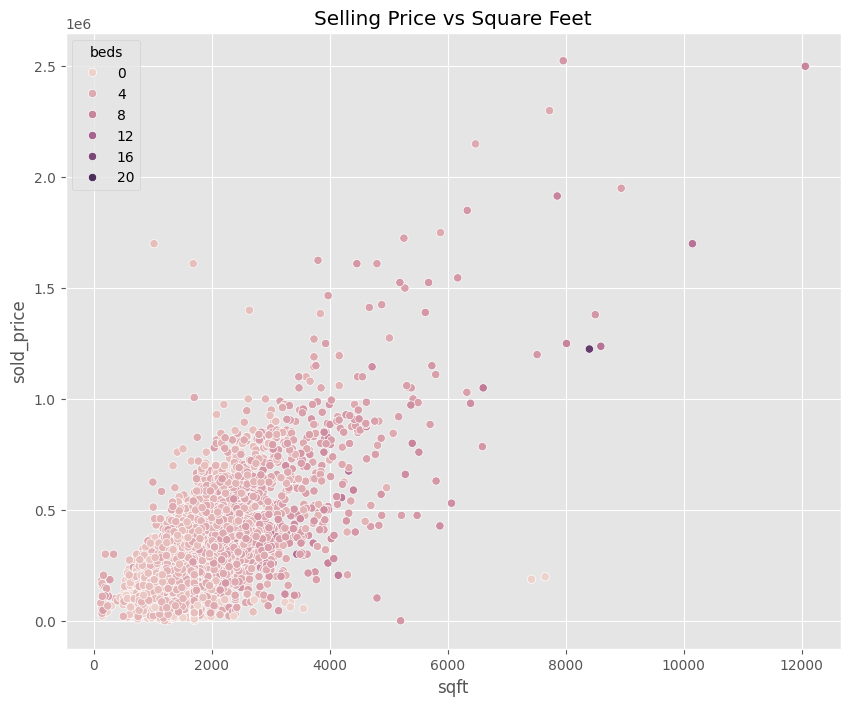

In [2028]:
ax = sns.scatterplot(x='sqft',
                     y='sold_price',
                     hue='beds',
                     data=df)
ax.set_title('Selling Price vs Square Feet')

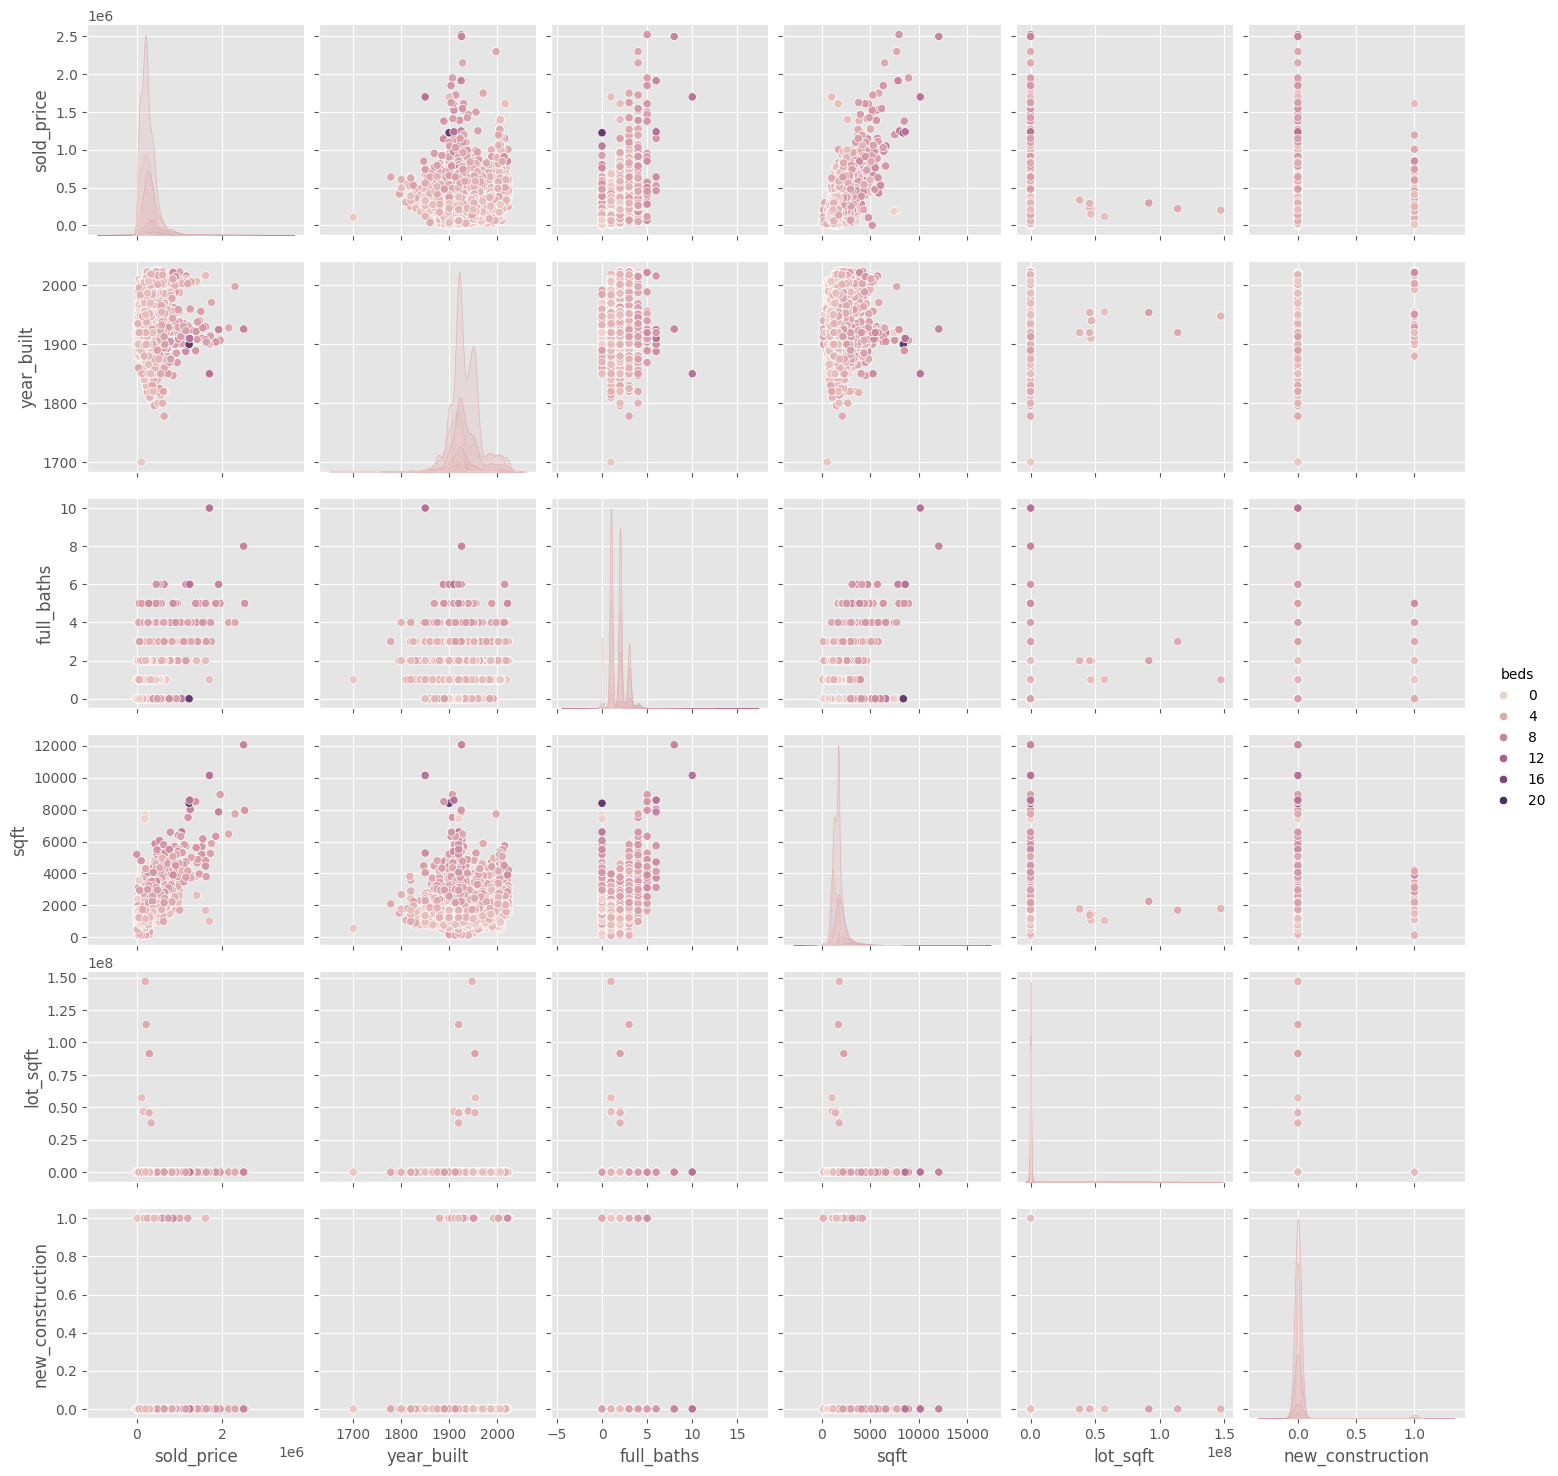

In [2029]:
sns.pairplot(df,
             vars=['sold_price', 'year_built',
                   'full_baths', 'sqft', 'lot_sqft',
                   'new_construction'],
                   hue='beds')
plt.show()

In [2030]:
df.columns

Index(['beds', 'full_baths', 'half_baths', 'sqft', 'year_built', 'days_on_mls',
       'list_date', 'sold_price', 'new_construction', 'lot_sqft', 'stories',
       'hoa_fee', 'parking_garage'],
      dtype='object')

In [2031]:
df_corr = df[['year_built', 
              'beds', 
              'full_baths', 
              'days_on_mls', 
              'sqft', 
              'lot_sqft', 
              'stories', 
              'hoa_fee', 
              'parking_garage',
              'sold_price']].corr()
df_corr


,year_built,beds,full_baths,days_on_mls,sqft,lot_sqft,stories,hoa_fee,parking_garage,sold_price
year_built,1.000000,-0.020180,0.109533,-0.018411,-0.003384,0.005734,-0.111363,0.384670,0.152110,0.145400
beds,-0.020180,1.000000,0.481131,-0.004670,0.513009,0.002732,0.209136,-0.182622,0.069979,0.393110
full_baths,0.109533,0.481131,1.000000,-0.046201,0.438775,-0.002890,0.423552,0.046200,0.121028,0.581274
days_on_mls,-0.018411,-0.004670,-0.046201,1.000000,0.038797,-0.008372,-0.047299,0.068422,0.034539,-0.085531
sqft,-0.003384,0.513009,0.438775,0.038797,1.000000,-0.004321,0.175868,0.003398,0.164838,0.657673
lot_sqft,0.005734,0.002732,-0.002890,-0.008372,-0.004321,1.000000,0.010509,-0.001122,0.004669,-0.008317
stories,-0.111363,0.209136,0.423552,-0.047299,0.175868,0.010509,1.000000,-0.271817,0.077450,0.223697
hoa_fee,0.384670,-0.182622,0.046200,0.068422,0.003398,-0.001122,-0.271817,1.000000,0.125317,0.179843
parking_garage,0.152110,0.069979,0.121028,0.034539,0.164838,0.004669,0.077450,0.125317,1.000000,0.207503
sold_price,0.145400,0.393110,0.581274,-0.085531,0.657673,-0.008317,0.223697,0.179843,0.207503,1.000000


<Axes: >

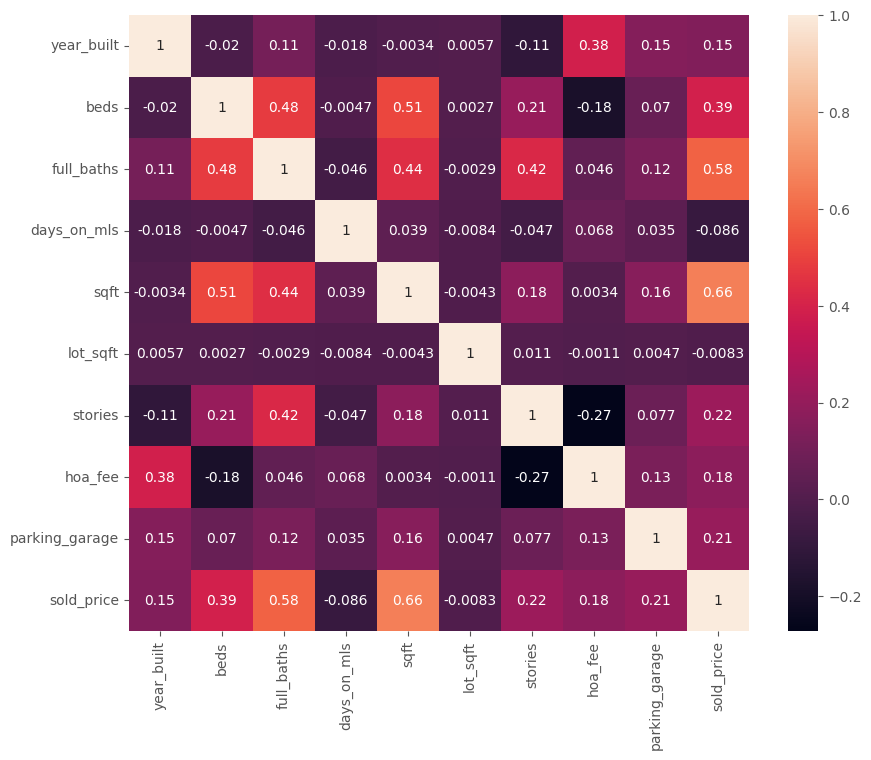

In [2032]:
sns.heatmap(df_corr, annot=True)

In [2033]:
df = df.drop(columns=['list_date'])

In [2034]:
df.columns

Index(['beds', 'full_baths', 'half_baths', 'sqft', 'year_built', 'days_on_mls',
       'sold_price', 'new_construction', 'lot_sqft', 'stories', 'hoa_fee',
       'parking_garage'],
      dtype='object')

In [2035]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7684 entries, 0 to 7710
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   beds              7684 non-null   float64
 1   full_baths        7684 non-null   float64
 2   half_baths        7684 non-null   float64
 3   sqft              7684 non-null   float64
 4   year_built        7684 non-null   float64
 5   days_on_mls       7684 non-null   float64
 6   sold_price        7684 non-null   int64  
 7   new_construction  7684 non-null   bool   
 8   lot_sqft          7684 non-null   float64
 9   stories           7684 non-null   float64
 10  hoa_fee           7684 non-null   float64
 11  parking_garage    7684 non-null   float64
dtypes: bool(1), float64(10), int64(1)
memory usage: 727.9 KB


In [2036]:
X, y = df.drop(columns='sold_price'), df['sold_price']

# Train and test split using sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=8)

# Initiate an XGBoost regression
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.2,
                max_depth = 10, alpha = 10, n_estimators = 10, random_state=8)

# Inspect parameters
xgb_reg.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.3,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.2,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 10,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 10,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 8,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'alpha': 10}

In [2037]:
# Fit the model
xgb_reg.fit(X_train, y_train)

# Get predictions
preds = xgb_reg.predict(X_test)

mse = mean_squared_error(preds, y_test)
mse

13790688256.0

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

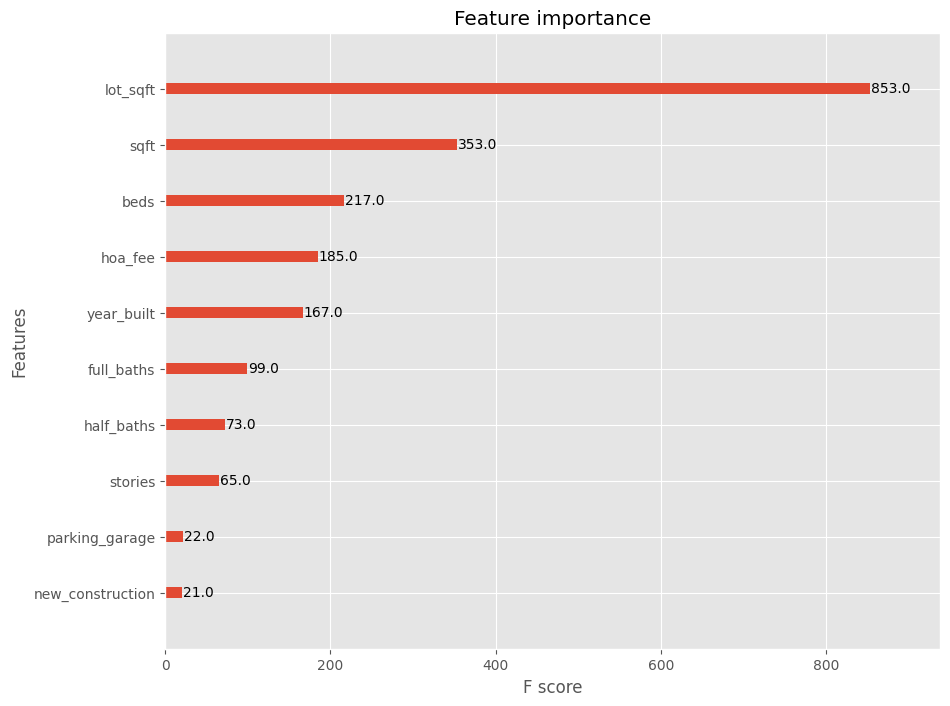

In [2038]:
matplotlib.rcParams['figure.figsize'] = (10.0, 8)
xgb.plot_importance(xgb_reg)

In [2039]:
RMSLE = np.sqrt(mean_squared_log_error(y_test, preds))
"The RMSLE score is %.5f" % RMSLE 

'The RMSLE score is 0.63908'

In [2040]:
r2 = r2_score(y_test, preds)

f"The R2 score is %.5f" % r2

'The R2 score is 0.66159'

In [2041]:
X_train.columns

Index(['beds', 'full_baths', 'half_baths', 'sqft', 'year_built', 'days_on_mls',
       'new_construction', 'lot_sqft', 'stories', 'hoa_fee', 'parking_garage'],
      dtype='object')

In [2042]:
input_data = np.array([[2, 1, 0, 900, 1800, 80, 0, 2000, 2, 0, 0]])

dmatrix = xgb.DMatrix(input_data)

predition_example = xgb_reg.predict(input_data)

predition_example

array([188266.36], dtype=float32)